imports

In [2]:
import os
import random
import numpy as np
from io import BytesIO

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow.keras.applications import InceptionV3

from ipywidgets import widgets

inspecting the training dataset

In [3]:
BASE_DIR = './rps'

rock_dir = os.path.join(BASE_DIR, 'rock')
paper_dir = os.path.join(BASE_DIR, 'paper')
scissors_dir = os.path.join(BASE_DIR, 'scissors')

print(f'total training rock images: {len(os.listdir(rock_dir))}')
print(f'total training paper images: {len(os.listdir(paper_dir))}')
print(f'total training scissors images: {len(os.listdir(scissors_dir))}')

rock_files = os.listdir(rock_dir)
paper_files = os.listdir(paper_dir)
scissors_files = os.listdir(scissors_dir)

total training rock images: 840
total training paper images: 840
total training scissors images: 840


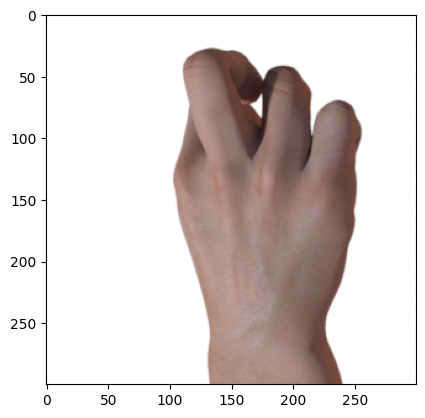

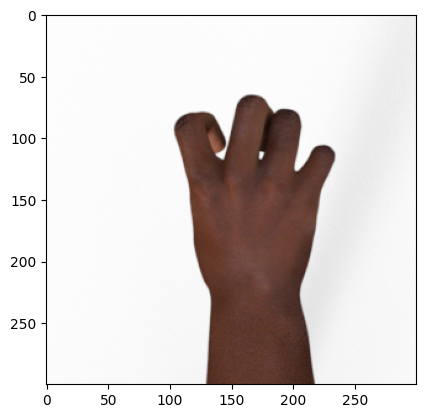

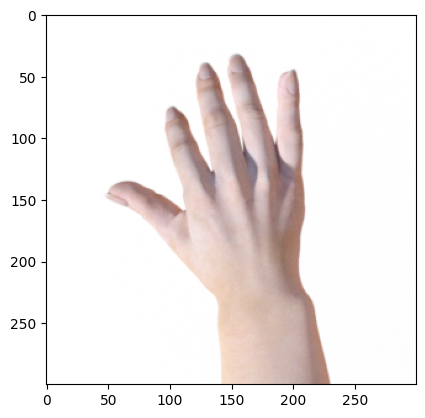

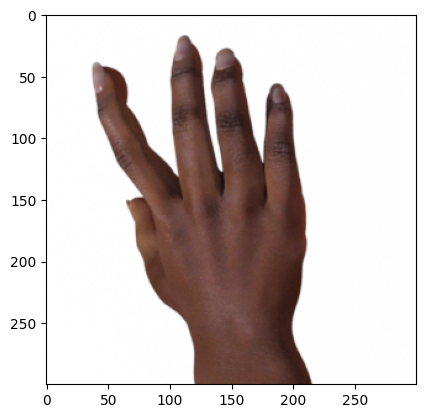

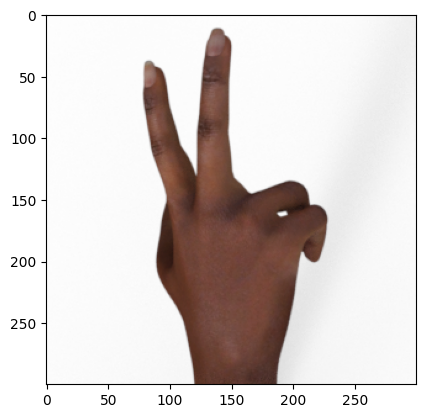

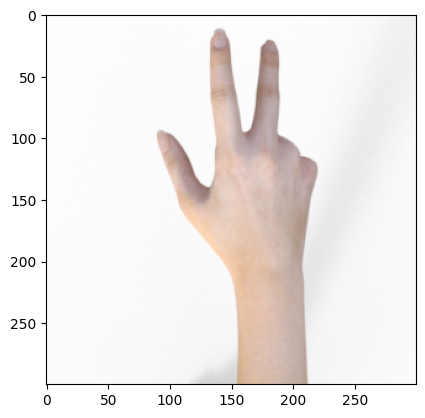

In [4]:
next_rock = [os.path.join(rock_dir, fname)
             for fname in random.sample(rock_files, k=2)]
next_paper = [os.path.join(paper_dir, fname)
              for fname in random.sample(paper_files, k=2)]
next_scissors = [os.path.join(scissors_dir, fname)
                 for fname in random.sample(scissors_files, k=2)]

for i, img_path in enumerate(next_rock+next_paper+next_scissors):
    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.show()

constructing the model

In [5]:
def create_pre_trained_model():
  
    pre_trained_model = tf.keras.applications.inception_v3.InceptionV3( 
        include_top=False, 
        input_shape=(150,150,3),
        weights='imagenet'
    ) 

    for layer in pre_trained_model.layers:
        layer.trainable = False

    return pre_trained_model

In [6]:
pre_trained_model = create_pre_trained_model()

num_total_params = pre_trained_model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in pre_trained_model.trainable_weights])

print(f"There are {num_total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

I0000 00:00:1753818297.955933   40766 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4985 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


There are 21,802,784 total parameters in this model.
There are 0 trainable parameters in this model.


In [7]:
pre_trained_model.summary()

Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 74, 74,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 74, 74,    │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 74, 74,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 72, 72,    │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 72, 72,    │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 72, 72,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 72, 72,    │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 72, 72,    │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 72, 72,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 35, 35,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 35, 35,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 35, 35,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 35, 35,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 33, 33,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 33, 33,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 33, 33,    │          0 │ batch_normalizat

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 21,802,784 (83.17 MB)

using DNN in our pre-trained model

In [8]:
def output_of_last_layer(pre_trained_model):
    
    last_layer = pre_trained_model.get_layer('mixed7')
    last_output = last_layer.output
    print('last layer output shape: ', last_output.shape)
    
    return last_output

In [9]:
last_output = pre_trained_model.get_layer('mixed7').output

final model

In [10]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.4),
    tf.keras.layers.RandomTranslation(0.2,0.2),
    tf.keras.layers.RandomContrast(0.4),
    tf.keras.layers.RandomZoom(0.2)
])

In [11]:
def create_final_model(pre_trained_model, last_output, num_classes=3):

    inputs = tf.keras.Input(shape=(150, 150, 3))
    x = data_augmentation(inputs)
    x = tf.keras.applications.inception_v3.preprocess_input(x)

    feature_extractor = tf.keras.Model(pre_trained_model.input, last_output)
    x = feature_extractor(x, training=False)

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-5),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [12]:
model = create_final_model(pre_trained_model, last_output)

total_params = model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 47,514,531 total parameters in this model.
There are 38,539,267 trainable parameters in this model.


pre-processing images

In [13]:
VAL_DIR = './rps-validation'
TEST_DIR = './rps-test-set'

In [14]:
def train_val_datasets():

    training_dataset = tf.keras.utils.image_dataset_from_directory( 
        directory=BASE_DIR,
        batch_size=32,
        image_size=(150,150),
        shuffle=True, 
        seed=42
    ) 
    
    validation_dataset = tf.keras.utils.image_dataset_from_directory( 
        directory=VAL_DIR,
        batch_size=32,
        image_size=(150,150),
        shuffle=True, 
        seed=42
    ) 
                                                                        
    return training_dataset, validation_dataset

In [16]:
training_dataset, validation_dataset = train_val_datasets()

Found 2520 files belonging to 3 classes.
Found 33 files belonging to 3 classes.


In [17]:
def preprocess(image, label):
    image = tf.keras.applications.inception_v3.preprocess_input(image)
    return image, label

training_dataset = training_dataset.map(preprocess)
validation_dataset = validation_dataset.map(preprocess)

In [18]:
class EarlyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs={}):
        if logs.get('accuracy') >= .90:
            self.model.stop_training = True

actual training

In [19]:
history = model.fit(
    training_dataset,
    epochs=50,
    validation_data = validation_dataset,
    callbacks = [EarlyCallback()],
    verbose = 2
)

Epoch 1/50


I0000 00:00:1753818346.847724   40877 cuda_dnn.cc:529] Loaded cuDNN version 91002


79/79 - 11s - 134ms/step - accuracy: 0.5802 - loss: 0.9083 - val_accuracy: 0.8182 - val_loss: 0.5397
Epoch 2/50
79/79 - 3s - 37ms/step - accuracy: 0.7381 - loss: 0.6344 - val_accuracy: 0.8788 - val_loss: 0.4058
Epoch 3/50
79/79 - 3s - 37ms/step - accuracy: 0.7770 - loss: 0.5314 - val_accuracy: 0.8182 - val_loss: 0.3743
Epoch 4/50
79/79 - 3s - 37ms/step - accuracy: 0.8123 - loss: 0.4736 - val_accuracy: 0.8182 - val_loss: 0.4101
Epoch 5/50
79/79 - 3s - 37ms/step - accuracy: 0.8266 - loss: 0.4279 - val_accuracy: 0.8788 - val_loss: 0.4618
Epoch 6/50
79/79 - 3s - 36ms/step - accuracy: 0.8393 - loss: 0.3964 - val_accuracy: 0.8485 - val_loss: 0.4720
Epoch 7/50
79/79 - 3s - 37ms/step - accuracy: 0.8468 - loss: 0.3852 - val_accuracy: 0.8788 - val_loss: 0.4860
Epoch 8/50
79/79 - 3s - 37ms/step - accuracy: 0.8635 - loss: 0.3552 - val_accuracy: 0.8182 - val_loss: 0.3439
Epoch 9/50
79/79 - 3s - 37ms/step - accuracy: 0.8722 - loss: 0.3390 - val_accuracy: 0.8485 - val_loss: 0.3409
Epoch 10/50
79/79 -

plots

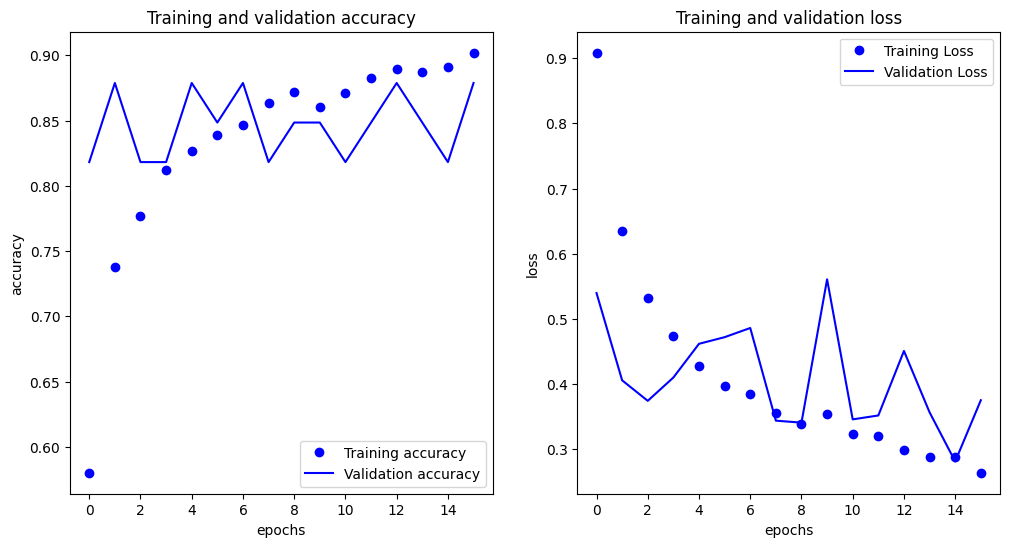

In [20]:
def plot_loss_acc(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  fig, ax = plt.subplots(1,2, figsize=(12, 6))
  ax[0].plot(epochs, acc, 'bo', label='Training accuracy')
  ax[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
  ax[0].set_title('Training and validation accuracy')
  ax[0].set_xlabel('epochs')
  ax[0].set_ylabel('accuracy')
  ax[0].legend()

  ax[1].plot(epochs, loss, 'bo', label='Training Loss')
  ax[1].plot(epochs, val_loss, 'b', label='Validation Loss')
  ax[1].set_title('Training and validation loss')
  ax[1].set_xlabel('epochs')
  ax[1].set_ylabel('loss')
  ax[1].legend()

  plt.show()

plot_loss_acc(history)

output is really disappointing 

random testing

In [24]:
uploader = widgets.FileUpload(accept="image/*", multiple=True)
display(uploader)
out = widgets.Output()
display(out)

def file_predict(filename, file, out):
    image = tf.keras.utils.load_img(file, target_size=(150, 150))
    image = tf.keras.utils.img_to_array(image)
    image = np.expand_dims(image, axis=0)

    prediction = model.predict(image, verbose=0)[0]

    with out:

        print(f'\nmodel output: {prediction}')
        
        prediction_index = np.argmax(prediction)
        
        classes = ["paper", "rock", "scissors"]
        
        predicted_class = classes[prediction_index]
        
        print(f'{filename} is {predicted_class}')


def on_upload_change(change):
        
    items = change.new
    for item in items: 
        file_jpgdata = BytesIO(item.content)
        file_predict(item.name, file_jpgdata, out)


uploader.observe(on_upload_change, names='value')

FileUpload(value=(), accept='image/*', description='Upload', multiple=True)

Output()

better to not implement such a sophisticated model for a small dataset to this,

paper -> best result

rock -> decent result

scissors -> trash result